# Importing Libraries and Reading CSV Files

In [1]:
import time
since = time.time()
!pip3 install python-gdcm

     |████████████████████████████████| 13.1 MB 6.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pydicom as dicom # Dicom (Digital Imaging in Medicine) - medical image datasets, storage and transfer
import os
from tqdm import tqdm # allows you to output a smart progress bar by wrapping around any iterable
import glob # retrieve files/pathnames matching a specified pattern
import pprint # pretty-print” arbitrary Python data structures
import ast # 
from pydicom.pixel_data_handlers.util import apply_voi_lut #
import wandb #

from PIL import Image
import shutil
import gdcm

path = '/kaggle/input/siim-covid19-detection/'
train_image_level = pd.read_csv(path + "train_image_level.csv")
train_study_level = pd.read_csv(path + "train_study_level.csv")

train_image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [3]:
train_image_level.describe()

,id,boxes,label,StudyInstanceUID
count,6334,4294,6334,6334
unique,6334,4294,4295,6054
top,30afde330074_image,"[{'x': 310.68868, 'y': 623.92906, 'width': 619...",none 1 0 0 1 1,0fd2db233deb
freq,1,1,2040,9



2040 ids without box

In [4]:
train_study_level_key = train_study_level.id.str[:-6]
training_set = pd.merge(left = train_study_level, right = train_image_level, how = 'right', left_on = train_study_level_key, right_on = 'StudyInstanceUID')
print(training_set.shape)

(6334, 9)


In [5]:
print(training_set.loc[0])

id_x                                                       5776db0cec75_study
Negative for Pneumonia                                                      0
Typical Appearance                                                          1
Indeterminate Appearance                                                    0
Atypical Appearance                                                         0
id_y                                                       000a312787f2_image
boxes                       [{'x': 789.28836, 'y': 582.43035, 'width': 102...
label                       opacity 1 789.28836 582.43035 1815.94498 2499....
StudyInstanceUID                                                 5776db0cec75
Name: 0, dtype: object


# Read Image in DCM format

## Searching Desired StudyInstanceUID in all Subfolders

In [6]:
def read_dcm(i):
    path_train = path + 'train/' + training_set.loc[i, 'StudyInstanceUID']
    #print(os.listdir(path_train))
    img_id = training_set.loc[i, 'id_y'].replace('_image','.dcm')
    
    for dirname, _, filenames in os.walk(path_train):
        for filename in filenames:
            path_img_id = os.path.join(dirname, filename)
            if path_img_id[-16:-4] == img_id:
                #print(path_img_id[-16:-4])
                break
      
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    data_file = dicom.dcmread(path_img_id)#(path_train + img_id)
    return img_id, data_file

def Image_resize(img,len_x):
    img = img.resize((len_x, len_x), Image.ANTIALIAS)
    return img

_,img = read_dcm(1)
print(img)

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.39810146631291240246278118572217078765
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 03a65300fa41
(0008, 0018) SOP Instance UID                    UI: 000c3a3f293f
(0008, 0020) Study Date                          DA: 'd09eda152722'
(0008, 0030) Study Time                          TM: '543adb46f494'
(0008, 0050) Accession Number                    SH: '1c2708371bc6'
(0008, 0060) Modality                            CS: 'CR'
(0010, 0010) Patient's Name                      PN: 'ef8c31f8dfdd'
(0010, 0020) P

# DCM Image as Pixel Array

Shape: (2320, 2832)


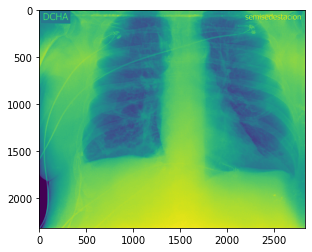

In [7]:
img_arr = img.pixel_array
plt.imshow(img_arr)
print('Shape:', img_arr.shape)

(array([  40473.,    7083.,  267588.,  756213.,  811724.,  690555.,
        1033042., 1503307., 1066989.,  393266.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

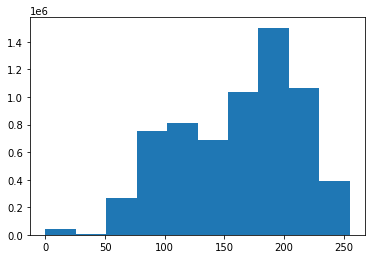

In [8]:
plt.hist(img_arr.ravel()) #calculating histogram

Image Shape: (2539, 3050)


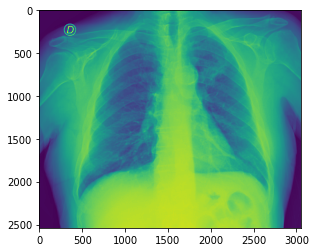

In [9]:
_,img = read_dcm(5) # Another Image
img_arr = img.pixel_array

plt.imshow(img_arr)
print('Image Shape:',img_arr.shape)

(array([ 443233.,  186707.,  528572.,  866834., 1006658., 1030330.,
        1248890., 1165411., 1121366.,  145949.]),
 array([  67. ,  469.8,  872.6, 1275.4, 1678.2, 2081. , 2483.8, 2886.6,
        3289.4, 3692.2, 4095. ]),
 <BarContainer object of 10 artists>)

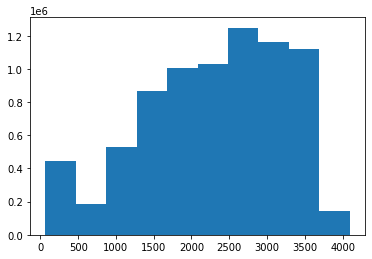

In [10]:
plt.hist(img_arr.ravel()) 

## Observation
### Some images have an intensity range of 0 to 255
### Some images have a higher intensity range.(can be 16 bit images/ 12 bit allocated)


# Histogram Equalization + Converting to RGB Images

In [11]:
def To_16bit(img_arr):
    min_arr = np.amin(img_arr)
    max_arr = np.amax(img_arr)
    range_array = max_arr - min_arr

    return np.round((img_arr-min_arr)/range_array*(np.power(2,16)*3-1)) 


def To_RGB(img_arr): #Extend to 24 bit then segment by 8 bit
    min_arr = np.amin(img_arr)
    max_arr = np.amax(img_arr)
    range_array = max_arr - min_arr
    
    lenx, leny = img_arr.shape
    rgbArray = np.zeros((lenx,leny,3), 'uint8')

    arr2 = np.round((img_arr-min_arr)/range_array*(np.power(2,24)-1))
    rgbArray[:,:, 0] = arr2 % np.power(2,8)
    arr2 = (arr2-rgbArray[:,:, 0])/np.power(2,8)
    rgbArray[:,:, 1] = arr2 % np.power(2,8)
    arr2 = (arr2-rgbArray[:,:, 1])/np.power(2,8)
    rgbArray[:,:, 2] = arr2 % np.power(2,8)
    
    return rgbArray
    
def To_RGB2(img_arr): #Extend to 16 bit then segment by 8 bit top(G), 8 bit bottom(R), 8 bit overall(B)
    min_arr = np.amin(img_arr)
    max_arr = np.amax(img_arr)
    range_array = max_arr - min_arr
    
    lenx, leny = img_arr.shape
    rgbArray = np.zeros((lenx,leny,3), 'uint8')

    arr2 = np.round((img_arr-min_arr)/range_array*(np.power(2,16)-1))
    rgbArray[:,:, 0] = arr2 % np.power(2,8)                 #8 bit bottom
    arr2 = np.floor(arr2/np.power(2,8))                     #8 bit top
    rgbArray[:,:, 1] = arr2 
    
    rgbArray[:,:, 2] = np.round((img_arr-min_arr)/range_array*(np.power(2,8)-1)) #8 bit overall
    
    
    return rgbArray    

Image Shape: (2539, 3050, 3)


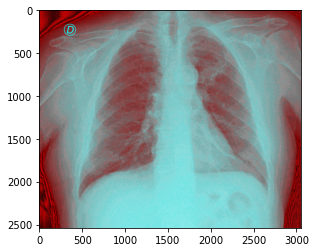

In [12]:
rgb_arr = To_RGB2(img_arr)
plt.imshow(rgb_arr)
print('Image Shape:', rgb_arr.shape)

# Plotting

### A few images are still grey (All of R,G,B components have the same value)

00b767b49fcd.dcm opacity
00b8180bd3a8.dcm none
00c1515729a8.dcm opacity
00e37a390f0f.dcm opacity
00e3a7e91a34.dcm opacity
00fb65888ddf.dcm opacity
010214f9b600.dcm none
0102b5cac730.dcm opacity
010433f32857.dcm opacity


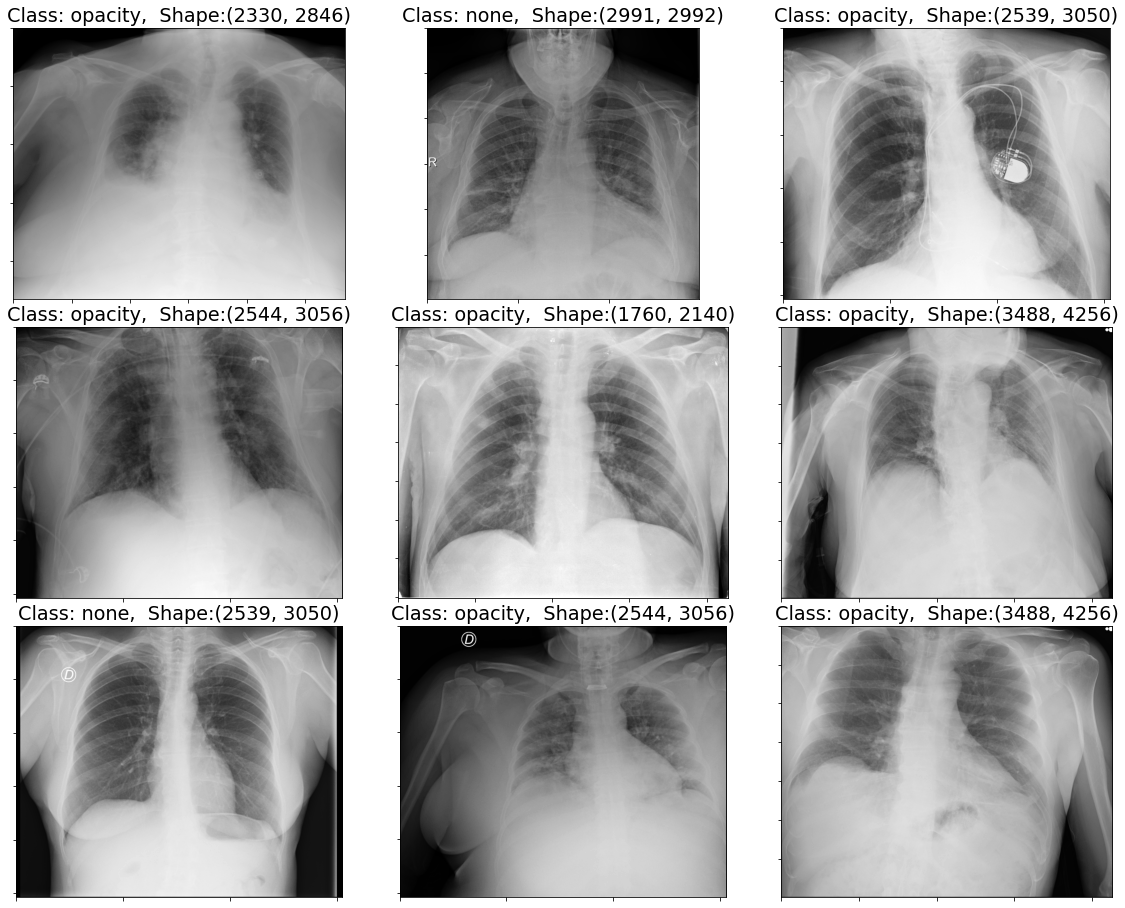

In [13]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

plt.rcParams['font.size'] = '16'
plt.rcParams['figure.dpi'] = 150
start_index = 20

for row in range(9):
    img_id, img = read_dcm(row + start_index)
    img = img.pixel_array
    #img = To_RGB2(img)
    #im = Image.fromarray(img)
    #im = Image_resize(im,512)
    #img = np.array(im)
    print(img_id, training_set.loc[row, 'label'].split(' ')[0])
    #if (training_set.loc[row + start_index,'boxes'] == training_set.loc[row + start_index,'boxes']):
    #    boxes = ast.literal_eval(training_set.loc[row + start_index,'boxes'])
    #    for box in boxes:
    #        p = matplotlib.patches.Rectangle((box['x'], box['y']),
    #                                          box['width'], box['height'],
    #                                          ec = 'r', fc = 'none', lw = 2.
    #                                        )
    #        axes[row].add_patch(p)
    axes[row].imshow(img, cmap = 'gray')
    axes[row].set_title('Class: '+training_set.loc[row, 'label'].split(' ')[0] + ',  Shape:' +str(img.shape))
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
plt.savefig('raw_data.pdf')  

In [14]:
time_elapsed = time.time() - since
print('Time from start {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Time from start 0m 40s


In [15]:
folderlocation = './Images'
if not os.path.exists(folderlocation):
        os.mkdir(folderlocation)

for iter_name in ['train', 'val', 'test']:
    folderlocation = './Images/' + iter_name
    if not os.path.exists(folderlocation):
            os.mkdir(folderlocation)
            
    folderlocation = './Images/' + iter_name +'/none'
    if not os.path.exists(folderlocation):
            os.mkdir(folderlocation)
            
    folderlocation = './Images/' + iter_name +'/opacity'
    if not os.path.exists(folderlocation):
            os.mkdir(folderlocation)
            
    folderlocation = './Images/' + iter_name +'/side'
    if not os.path.exists(folderlocation):
            os.mkdir(folderlocation)
    


In [16]:
iter_split = 0
train_test_split = 0
folderlocation = './Images/'

box=0 #Except the initial one previous box weiil be considered

for row in range(len(training_set)): # len(training_set)
    img_id, img = read_dcm(row)
    img = img.pixel_array
    
    iter_split = iter_split +1
    
    
    # for some opacity images, only taking the opacity portion
    if (training_set.loc[row,'boxes'] == training_set.loc[row,'boxes']):
        if iter_split%10 < 2:
            box = ast.literal_eval(training_set.loc[row,'boxes']) [0]
            img = img[int(box['y']):int(box['y']+box['height']), int(box['x']):int(box['x']+box['width'])]
        
    # for some none images, only taking a region or potential opacity
    if training_set.loc[row, 'label'].split(' ')[0] == 'none':
        if iter_split%10 < 2 and box:
            img = img[int(box['y']):int(box['y']+box['height']), int(box['x']):int(box['x']+box['width'])]
            
            
    # Some images of sides     
    if iter_split%8 == 0 and box:
        if (training_set.loc[row,'boxes'] == training_set.loc[row,'boxes']):
            box = ast.literal_eval(training_set.loc[row,'boxes']) [0]
        img_2 = img[0:int(box['y']), int(box['x']):int(box['x']+box['width'])].copy()
        
    if iter_split%8 == 1 and box:
        if (training_set.loc[row,'boxes'] == training_set.loc[row,'boxes']):
            box = ast.literal_eval(training_set.loc[row,'boxes']) [0]
        img_2 = img[0:int(box['y']), 0:int(box['x'])].copy()
        
    if iter_split%8 == 2 and box:
        if (training_set.loc[row,'boxes'] == training_set.loc[row,'boxes']):
            box = ast.literal_eval(training_set.loc[row,'boxes']) [0]
        img_2 = img[int(box['y']):int(box['y']+box['height']), 0:int(box['x'])].copy()
        
    if iter_split%8 == 3 and box:
        if (training_set.loc[row,'boxes'] == training_set.loc[row,'boxes']):
            box = ast.literal_eval(training_set.loc[row,'boxes']) [0]
        img_2 = img[int(box['y']+box['height']):img.shape[0], int(box['x']):int(box['x']+box['width'])].copy()
        
                        
    if iter_split%8 <4 and box:
        if img_2.shape[0] !=0 and img_2.shape[1]!=0:
            img_destination_2 = folderlocation +'train/side/'+img_id[:-4] +'.jpeg'
            
            if train_test_split ==1:
                img_destination_2 = folderlocation +'val/side/'+img_id[:-4] +'.jpeg'
                train_test_split = train_test_split+1
                
            if train_test_split ==0:
                img_destination_2 = folderlocation +'test/side/'+img_id[:-4] +'.jpeg'
                train_test_split = train_test_split+1
                
            img_3 = To_RGB2(img_2)
            im = Image.fromarray(img_3)
            im = Image_resize(im,512)
            im.save(img_destination_2,  cmap='gray')
    if img.shape[0] !=0 and img.shape[1]!=0:
        img = To_RGB2(img)    
    
        img_destination = folderlocation +'train/'+ training_set.loc[row, 'label'].split(' ')[0] +'/'+img_id[:-4] +'.jpeg'

        if iter_split%20 == 19:
            img_destination = folderlocation +'test/'+ training_set.loc[row, 'label'].split(' ')[0] +'/'+img_id[:-4] +'.jpeg'
        if iter_split%20 == 18:
            img_destination = folderlocation +'val/'+ training_set.loc[row, 'label'].split(' ')[0] +'/'+img_id[:-4] +'.jpeg'

        im = Image.fromarray(img)
        im = Image_resize(im,512)
        im.save(img_destination,  cmap='gray')
    
    if row%500 == 499:
        time_elapsed = time.time() - since
        print('Time from start {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Percentage Complete:', np.round(10000*(row+1)/6334)/100)
    
    
print('100% Complete.')    

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


Time from start 8m 19s
Percentage Complete: 7.89
Time from start 16m 30s
Percentage Complete: 15.79
Time from start 24m 46s
Percentage Complete: 23.68
Time from start 32m 55s
Percentage Complete: 31.58


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in remainder
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Time from start 41m 13s
Percentage Complete: 39.47
Time from start 48m 59s
Percentage Complete: 47.36
Time from start 57m 2s
Percentage Complete: 55.26
Time from start 65m 1s
Percentage Complete: 63.15
Time from start 73m 9s
Percentage Complete: 71.05
Time from start 81m 17s
Percentage Complete: 78.94
Time from start 89m 15s
Percentage Complete: 86.83
Time from start 97m 53s
Percentage Complete: 94.73
100% Complete.


In [17]:
shutil.make_archive('SIIM-FISABIO-RSNA-JPEG', 'zip', folderlocation)
shutil.rmtree(folderlocation)